#### Loading and Processing Images
- `tf.keras.utils.image_dataset_from_directory`
- `tf.keras.layers.Rescaling`

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

2023-12-18 06:40:00.209635: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-18 06:40:00.246688: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 06:40:00.246705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 06:40:00.247745: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 06:40:00.254653: I tensorflow/core/platform/cpu_feature_guar

#### Download Flowers Dataset

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

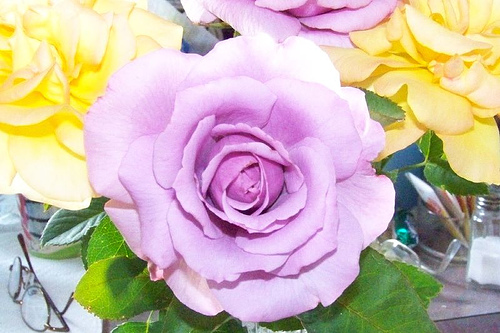

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

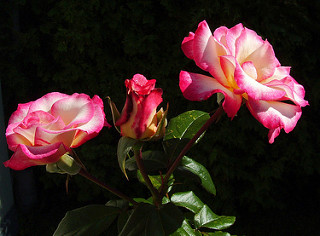

In [5]:
PIL.Image.open(str(roses[1]))

#### Load with Keras Utility

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset='training',
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2023-12-18 06:40:10.996592: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 06:40:11.049743: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 06:40:11.049777: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 06:40:11.053859: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 06:40:11.053903: I external/local_xla/xla/stream_executor

In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset='validation',
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


#### Visualize Data

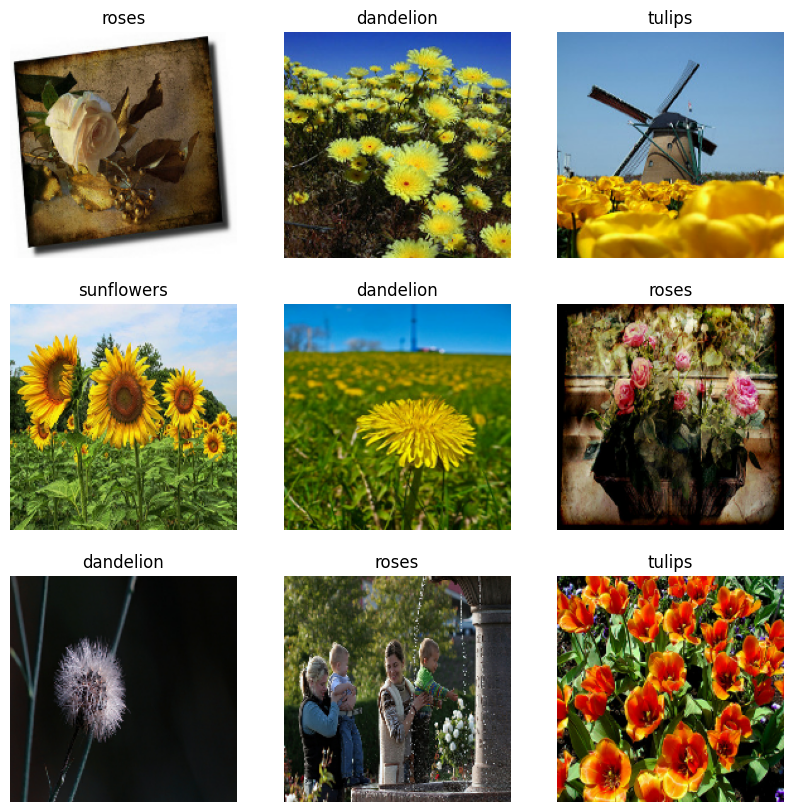

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [12]:
# Standardize the data
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Either use the layer by applying it to the dataset, or include it in the model
normalized_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


#### Train Model

In [13]:
# Configure dataset for performace with cache() and prefetch()
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
from keras import Sequential
from keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense

num_classes = 5
channels = 3
input_shape = (img_height, img_width, channels)

model = Sequential([
    Rescaling(1./255),
    Conv2D(32, 3, activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3


2023-12-18 06:40:17.305891: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-18 06:40:17.428890: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-18 06:40:17.950972: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcbac33fa40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-18 06:40:17.951021: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2023-12-18 06:40:17.956187: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702910418.036168 1658261 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 [==============================] - 7s 37ms/step - loss: 1.2652 - accuracy: 0.4646 - val_loss: 1.1218 - val_accuracy: 0.5545
Epoch 2/3
92/92 [==============================] - 1s 16ms/step - loss: 1.0615 - accuracy: 0.5756 - val_loss: 0.9882 - val_accuracy: 0.6022
Epoch 3/3
92/92 [==============================] - 2s 18ms/step - loss: 0.8932 - accuracy: 0.6448 - val_loss: 0.9358 - val_accuracy: 0.6308


#### Custom image input pipeline
- `tf.data`

In [57]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [58]:
for f in list_ds.take(5):
  print(f.numpy())

b'/home/kmirijan/.keras/datasets/flower_photos/roses/3292654244_4a220ab96f_m.jpg'
b'/home/kmirijan/.keras/datasets/flower_photos/dandelion/14053173516_a00150a919_m.jpg'
b'/home/kmirijan/.keras/datasets/flower_photos/tulips/4890786831_91bb82a9e4_n.jpg'
b'/home/kmirijan/.keras/datasets/flower_photos/dandelion/6972675188_37f1f1d6f6.jpg'
b'/home/kmirijan/.keras/datasets/flower_photos/daisy/4268817944_cdbdb226ae.jpg'


In [59]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [60]:
# Test train split
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [61]:
# Convert the file path to (img, label) pair
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep) # Splits by the seperator argument into an array of constituent parts
    one_hot = parts[-2] == class_names # Make an array where the index is True if the "part" of the file name is a class name
    return tf.argmax(one_hot) # Get the index of the class name

def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3) # Convert the compressed string into a 3D uint8 tensor
    return tf.image.resize(img, [img_height, img_width]) # Resize the image to dezired shape

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path) # Load raw data from file as a string
    img = decode_img(img)
    return img, label

In [62]:
# Run process_path across the file_paths and load/process the data in parallel
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [63]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(180, 180, 3)
()


In [64]:
for image,label in val_ds.take(100):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  2
Image shape:  (180, 180, 3)
Label:  1
Image shape:  (180, 180, 3)
Label:  4
Image shape:  (180, 180, 3)
Label:  1
Image shape:  (180, 180, 3)
Label:  0
Image shape:  (180, 180, 3)
Label:  4
Image shape:  (180, 180, 3)
Label:  1
Image shape:  (180, 180, 3)
Label:  3
Image shape:  (180, 180, 3)
Label:  3
Image shape:  (180, 180, 3)
Label:  3
Image shape:  (180, 180, 3)
Label:  2
Image shape:  (180, 180, 3)
Label:  0
Image shape:  (180, 180, 3)
Label:  0
Image shape:  (180, 180, 3)
Label:  3
Image shape:  (180, 180, 3)
Label:  1
Image shape:  (180, 180, 3)
Label:  0
Image shape:  (180, 180, 3)
Label:  1
Image shape:  (180, 180, 3)
Label:  0
Image shape:  (180, 180, 3)
Label:  4
Image shape:  (180, 180, 3)
Label:  1
Image shape:  (180, 180, 3)
Label:  4
Image shape:  (180, 180, 3)
Label:  2
Image shape:  (180, 180, 3)
Label:  2
Image shape:  (180, 180, 3)
Label:  4
Image shape:  (180, 180, 3)
Label:  1
Image shape:  (180, 180, 3)
Label:  1
Image shape:

#### Configure data for performace
- Well shuffled
- Batching
- Batches available quickly

In [65]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [66]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


2023-12-18 06:58:24.633062: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2023-12-18 06:58:27.448524: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


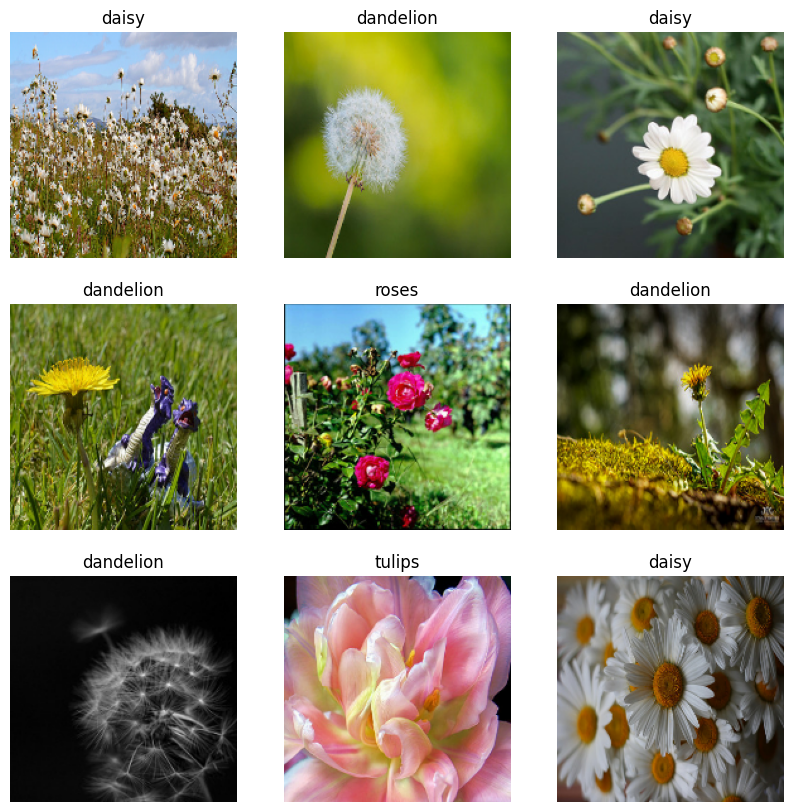

In [67]:
# Visualize
# image_batch, label_batch = next(iter(train_ds))

# plt.figure(figsize=(10,10))
# for i in range(9):
#     ax = plt.subplot(3, 3, i+1)
#     plt.imshow(image_batch[i].numpy().astype('uint8'))
#     plt.title(class_names[label_batch[i]])
#     plt.axis('off')

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [68]:
# Try functional and see what happens
# model = Sequential([
#     Rescaling(1./255),
#     Conv2D(32, 3, activation='relu', input_shape=input_shape),
#     MaxPooling2D(),
#     Conv2D(32, 3, activation='relu'),
#     MaxPooling2D(),
#     Conv2D(32, 3, activation='relu'),
#     MaxPooling2D(),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dense(num_classes)
# ])

import keras
img_inputs = keras.Input(shape=input_shape)
x = Rescaling(1./255)(img_inputs)
x = Conv2D(32, 3, activation='relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes)(x)
model_func = keras.Model(inputs=img_inputs, outputs=output, name="flowers_model")

Model: "flowers_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 253472)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               32444544  
                                                     

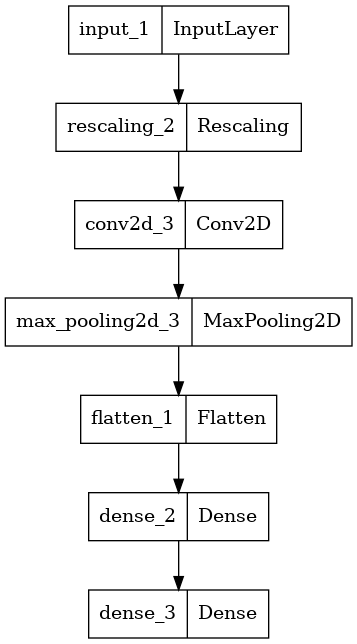

In [69]:
model.summary()
keras.utils.plot_model(model, "flowers_model.png")

In [70]:
# Continue training
model_func.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_func.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3


92/92 [==============================] - 3s 22ms/step - loss: 5.1431 - accuracy: 0.4022 - val_loss: 1.1435 - val_accuracy: 0.5395
Epoch 2/3
92/92 [==============================] - 2s 19ms/step - loss: 0.9906 - accuracy: 0.6148 - val_loss: 1.1154 - val_accuracy: 0.5749
Epoch 3/3
92/92 [==============================] - 2s 18ms/step - loss: 0.6319 - accuracy: 0.7868 - val_loss: 1.0228 - val_accuracy: 0.5886


In [71]:
model.summary()

Model: "flowers_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 253472)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               32444544  
                                                     

In [72]:
# And now there's overfitting
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
92/92 [==============================] - 2s 21ms/step - loss: 0.3928 - accuracy: 0.8883 - val_loss: 0.3770 - val_accuracy: 0.8815
Epoch 2/3
92/92 [==============================] - 2s 18ms/step - loss: 0.1142 - accuracy: 0.9765 - val_loss: 0.4172 - val_accuracy: 0.8937
Epoch 3/3
92/92 [==============================] - 2s 18ms/step - loss: 0.0320 - accuracy: 0.9949 - val_loss: 0.3968 - val_accuracy: 0.9060


#### Use Tensorflow Datasets

In [74]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

In [75]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


2023-12-18 07:10:08.739411: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


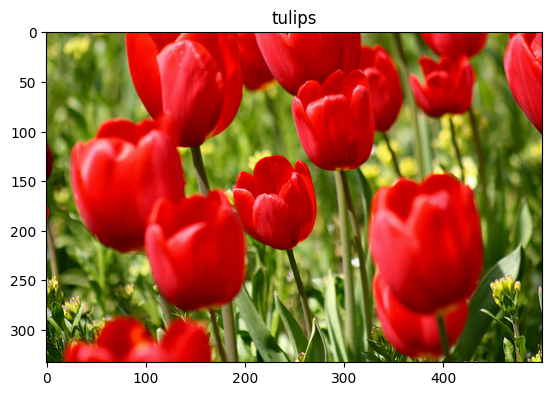

In [77]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
plt.imshow(image)
plt.title(get_label_name(label))
plt.show()

In [78]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)